<a href="https://colab.research.google.com/github/CamilaForlin22/7DaysofCode/blob/main/JogoDeVestir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Célula 1: Configuração Inicial, Imports e Autenticação no Google Drive

# Instalações de bibliotecas (execute apenas uma vez)
!pip install Pillow # Para manipulação de imagens
!pip install IPython # Para exibir imagens no notebook

# Imports Essenciais
import os
import random
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPImage, clear_output
import io
import uuid # Para gerar códigos identificadores
import pickle # Para serializar e desserializar objetos do jogo
import json # Para o banco de dados do desenvolvedor e o catálogo público
import time # Para timestamps


# --- Autenticação no Google Drive ---
from google.colab import drive

print("Montando o Google Drive para persistência de dados...")
try:
    drive.mount('/content/drive')
    print("Google Drive montado com sucesso!")
except Exception as e:
    print(f"Erro ao montar o Google Drive: {e}")
    print("O salvamento persistente e os catálogos (desenvolvedor/público) não estarão disponíveis.")
    # Define GAME_SAVE_PATH como None para desativar funcionalidades que dependem do Drive
    GAME_SAVE_PATH = None

# Define o caminho onde os arquivos de jogo serão salvos no Google Drive
if 'GAME_SAVE_PATH' not in locals() or GAME_SAVE_PATH is None: # Se não foi definido devido a erro
    GAME_SAVE_PATH = '/content/drive/MyDrive/meu_jogo_loja_roupa/'

# Define os nomes dos arquivos do banco de dados do desenvolvedor e do catálogo público
DEV_DB_STORES_FILE = os.path.join(GAME_SAVE_PATH, 'dev_db_stores.json')
DEV_DB_PIECES_FILE = os.path.join(GAME_SAVE_PATH, 'dev_db_pieces.json')
PUBLIC_CATALOG_FILE = os.path.join(GAME_SAVE_PATH, 'public_catalog.json')


# Verifica se o diretório de salvamento existe, se não, tenta criar
if GAME_SAVE_PATH: # Só tenta criar se o Drive foi montado com sucesso
    if not os.path.exists(GAME_SAVE_PATH):
        print(f"Criando diretório de salvamento: {GAME_SAVE_PATH}")
        try:
            os.makedirs(GAME_SAVE_PATH)
            print("Diretório criado com sucesso.")
        except Exception as e:
            print(f"Erro ao criar diretório: {e}. Verifique as permissões do Drive.")
            GAME_SAVE_PATH = None # Desabilita o salvamento se não puder criar o diretório
else:
    print("Não foi possível configurar o caminho de salvamento. Funções de persistência desabilitadas.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00
Montando o Google Drive para persistência de dados...
Erro ao montar o Google Drive: Error: credential propagation was unsuccessful
O salvamento persistente e os catálogos (desenvolvedor/público) não estarão disponíveis.
Criando diretório de salvamento: /content/drive/MyDrive/meu_jogo_loja_roupa/
Diretório criado com sucesso.


In [7]:
# Célula 2: Variáveis Globais, Funções de Persistência e Banco de Dados do Desenvolvedor/Público

# --- Variáveis globais para o jogo ---
STORE_NAME = ""
STORE_ID = ""
STORE_LOGO = None
CATALOG = [] # Catálogo de peças criadas pelo jogador atual (inclui a imagem binária)
OWNED_PIECES_IDS = set() # IDs das peças que o jogador "comprou" do catálogo público


# --- Funções para o Banco de Dados do Desenvolvedor (JSON) ---

def load_dev_db(filepath):
    """Carrega dados de um arquivo JSON do banco de dados do desenvolvedor."""
    if not GAME_SAVE_PATH or not os.path.exists(filepath):
        return []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except (json.JSONDecodeError, FileNotFoundError, Exception) as e:
        # print(f"AVISO: Erro ao carregar {filepath}: {e}. Iniciando vazio/criando novo.") # Comentado para não poluir o console
        return []

def save_dev_db(data, filepath):
    """Salva dados em um arquivo JSON do banco de dados do desenvolvedor."""
    if not GAME_SAVE_PATH:
        # print(f"AVISO: Caminho de salvamento não configurado. Não é possível salvar em {filepath}.") # Comentado
        return
    try:
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        # print(f"Dados salvos em {filepath}") # Comentar para evitar spam no console
    except Exception as e:
        print(f"ERRO: Erro ao salvar em {filepath}: {e}")

def register_store_in_dev_db(store_name, store_id):
    """Registra informações da loja no banco de dados do desenvolvedor."""
    stores_data = load_dev_db(DEV_DB_STORES_FILE)

    # Verifica se a loja já existe para não duplicar entradas no DB do desenvolvedor
    if not any(s['store_id'] == store_id for s in stores_data):
        stores_data.append({
            'store_id': store_id,
            'store_name': store_name,
            'created_at': time.strftime("%Y-%m-%d %H:%M:%S")
        })
        save_dev_db(stores_data, DEV_DB_STORES_FILE)
        # print("Loja registrada no banco de dados do desenvolvedor.") # Comentado

def register_piece_in_dev_db(piece_data):
    """Registra informações da peça no banco de dados do desenvolvedor."""
    pieces_data = load_dev_db(DEV_DB_PIECES_FILE)
    pieces_data.append(piece_data)
    save_dev_db(pieces_data, DEV_DB_PIECES_FILE)
    # print("Peça registrada no banco de dados do desenvolvedor.") # Comentado


# --- Funções para o Catálogo Público (JSON) ---

def upload_image_to_public_host(image: Image.Image):
    """
    Simula o upload de uma imagem para um serviço de hospedagem pública e retorna um URL.
    IMPORTANTE: Em um jogo real, esta função seria a integração com uma API real (Imgur, Cloudinary, etc.)
    e o URL retornado seria um link real para a imagem hospedada.
    """
    print("\nSimulando upload da imagem para hospedagem pública...")
    # Salvando a imagem temporariamente no Colab para simular o "upload"

    # Gera um nome de arquivo temporário
    temp_filename = f"piece_{uuid.uuid4()}.png"
    temp_filepath = os.path.join(GAME_SAVE_PATH, temp_filename)

    try:
        # Salva a imagem no Drive na mesma pasta do jogo (para fins de persistência)
        image.save(temp_filepath)
        print(f"Imagem temporariamente salva em: {temp_filepath}")

        # Gera um URL de placeholder. Este URL NÃO CARREGA A IMAGEM REALMENTE no Colab,
        # a menos que você configure um servidor web ou um serviço de compartilhamento direto do Drive.
        # Ele serve para demonstrar a estrutura do catálogo público.
        public_url = f"https://mock-image-host.com/clothes/{temp_filename}"
        print(f"URL público gerado (placeholder): {public_url}")
        return public_url
    except Exception as e:
        print(f"ERRO: Não foi possível simular o upload para hospedagem pública: {e}")
        return None


def update_public_catalog(piece_data):
    """Adiciona uma nova peça ao catálogo público global (JSON)."""
    if not GAME_SAVE_PATH:
        # print("AVISO: Caminho de salvamento não configurado. Não é possível atualizar o catálogo público.") # Comentado
        return

    public_catalog_items = load_dev_db(PUBLIC_CATALOG_FILE) # Reutiliza load_dev_db

    # Adiciona a nova peça ao catálogo público
    public_catalog_items.append(piece_data)

    save_dev_db(public_catalog_items, PUBLIC_CATALOG_FILE) # Reutiliza save_dev_db
    print("Catálogo público atualizado com sucesso!")


# --- Funções de Salvar e Carregar o Estado do Jogo (usando pickle) ---

def save_game_state():
    """Salva o estado atual do jogo (loja, catálogo local, peças possuídas) no Google Drive."""
    if not GAME_SAVE_PATH:
        print("Caminho de salvamento não configurado. Não é possível salvar o jogo.")
        return

    game_state = {
        'store_name': STORE_NAME,
        'store_id': STORE_ID,
        'store_logo_bytes': STORE_LOGO.tobytes() if STORE_LOGO else None,
        'store_logo_size': STORE_LOGO.size if STORE_LOGO else None,
        'store_logo_mode': STORE_LOGO.mode if STORE_LOGO else None,
        'catalog': [], # Catálogo de peças do jogador, incluindo imagens
        'owned_pieces_ids': list(OWNED_PIECES_IDS) # IDs das peças compradas do catálogo público
    }

    # Serializa cada objeto ClothingPiece no catálogo local
    for piece in CATALOG:
        game_state['catalog'].append({
            'name': piece.name,
            'category': piece.category,
            'image_bytes': piece.image.tobytes(), # Salva a imagem como bytes para o jogo local
            'image_size': piece.image.size,
            'image_mode': piece.image.mode,
            'piece_id': piece.piece_id,
            'store_id': piece.store_id
        })

    try:
        with open(os.path.join(GAME_SAVE_PATH, 'game_state.pkl'), 'wb') as f:
            pickle.dump(game_state, f)
        print("\nEstado do jogo salvo com sucesso!")
    except Exception as e:
        print(f"\nERRO: Erro ao salvar o estado do jogo: {e}")

def load_game_state():
    """Carrega o estado do jogo do Google Drive, se existir."""
    global STORE_NAME, STORE_ID, STORE_LOGO, CATALOG, OWNED_PIECES_IDS

    if not GAME_SAVE_PATH or not os.path.exists(os.path.join(GAME_SAVE_PATH, 'game_state.pkl')):
        print("Nenhum estado de jogo salvo encontrado. Iniciando um novo jogo.")
        return False

    try:
        with open(os.path.join(GAME_SAVE_PATH, 'game_state.pkl'), 'rb') as f:
            game_state = pickle.load(f)

        STORE_NAME = game_state.get('store_name', '')
        STORE_ID = game_state.get('store_id', '')

        # Recria o objeto Image para a logo
        logo_bytes = game_state.get('store_logo_bytes')
        logo_size = game_state.get('store_logo_size')
        logo_mode = game_state.get('store_logo_mode')
        if logo_bytes and logo_size and logo_mode:
            STORE_LOGO = Image.frombytes(logo_mode, logo_size, logo_bytes)
        else:
            STORE_LOGO = None # Nenhuma logo salva

        CATALOG = []
        for piece_data in game_state.get('catalog', []):
            # Recria o objeto Image para cada peça de roupa no catálogo local
            piece_image = Image.frombytes(piece_data['image_mode'], piece_data['image_size'], piece_data['image_bytes'])
            piece = ClothingPiece(
                piece_data['name'],
                piece_data['category'],
                piece_image,
                piece_data['piece_id'],
                piece_data['store_id']
            )
            CATALOG.append(piece)

        # Carrega os IDs das peças possuídas pelo jogador
        OWNED_PIECES_IDS = set(game_state.get('owned_pieces_ids', []))

        print("\nEstado do jogo carregado com sucesso!")
        return True

    except Exception as e:
        print(f"\nERRO: Erro ao carregar o estado do jogo: {e}")
        print("Iniciando um novo jogo.")
        return False


# --- Função de Setup da Loja (chamada no início do jogo) ---
def setup_store_initial():
    global STORE_NAME, STORE_ID, STORE_LOGO

    # Tenta carregar o jogo salvo
    if load_game_state():
        print(f"Bem-vindo(a) de volta à {STORE_NAME}!")
        # Mesmo que carregue, garantimos que a loja esteja no DB do desenvolvedor
        register_store_in_dev_db(STORE_NAME, STORE_ID)
        return

    # Se não carregou um jogo salvo, configura uma nova loja
    STORE_NAME = input("Bem-vindo(a)! Qual o nome da sua loja de roupas? ")
    STORE_ID = str(uuid.uuid4())[:8] # Gera um ID curto

    # Registra a nova loja no banco de dados do desenvolvedor
    register_store_in_dev_db(STORE_NAME, STORE_ID)

    print(f"\nÓtimo! Sua loja '{STORE_NAME}' foi criada com o ID: {STORE_ID}")

    # --- NOVIDADE: Opção para gerar logo padrão ---
    while True:
        print("\nAgora, vamos configurar a logo da sua loja.")
        print("Você pode:")
        print("1. Fazer upload de uma logo (PNG preferencialmente, com fundo transparente)")
        print("2. Gerar uma logo padrão (com o nome da loja)")

        logo_choice = input("Digite sua escolha (1 ou 2): ").strip()

        if logo_choice == '1':
            try:
                from google.colab import files
                uploaded = files.upload() # Abre a caixa de diálogo de upload

                if uploaded:
                    logo_filename = list(uploaded.keys())[0]
                    STORE_LOGO = Image.open(io.BytesIO(uploaded[logo_filename]))
                    if STORE_LOGO.mode != 'RGBA':
                        STORE_LOGO = STORE_LOGO.convert('RGBA')
                    STORE_LOGO = STORE_LOGO.resize((100, 100), Image.Resampling.LANCZOS)
                    print(f"Logo '{logo_filename}' carregada com sucesso!")
                    break # Sai do loop se o upload for bem-sucedido
                else:
                    print("Nenhum arquivo de logo foi carregado. Por favor, tente novamente ou escolha a opção 2.")
            except Exception as e:
                print(f"ERRO: Erro ao carregar logo: {e}. Por favor, tente novamente ou escolha a opção 2.")
        elif logo_choice == '2':
            print("Gerando logo padrão...")
            STORE_LOGO = Image.new('RGBA', (150, 50), (255, 255, 255, 0)) # Fundo transparente
            d = ImageDraw.Draw(STORE_LOGO)
            try:
                # Tenta usar uma fonte padrão do sistema Colab, ou uma fonte simples
                font = ImageFont.truetype("arial.ttf", 20)
            except IOError:
                font = ImageFont.load_default()
            d.text((10, 10), STORE_NAME[:12] + " L.", font=font, fill=(0, 0, 0, 128)) # Texto preto semi-transparente
            print("Logo padrão gerada com sucesso!")
            break # Sai do loop
        else:
            print("Escolha inválida. Por favor, digite '1' para upload ou '2' para gerar logo padrão.")


# Chama a função de setup inicial logo no carregamento do notebook
setup_store_initial()

Nenhum estado de jogo salvo encontrado. Iniciando um novo jogo.
Bem-vindo(a)! Qual o nome da sua loja de roupas? Ms PB

Ótimo! Sua loja 'Ms PB' foi criada com o ID: 66304335

Agora, vamos configurar a logo da sua loja.
Você pode:
1. Fazer upload de uma logo (PNG preferencialmente, com fundo transparente)
2. Gerar uma logo padrão (com o nome da loja)
Digite sua escolha (1 ou 2): 2
Gerando logo padrão...
Logo padrão gerada com sucesso!


In [9]:
# Célula 3: A Costureira (NPC) e Interação Inicial

def costureira_saudacao():
    clear_output(wait=True) # Limpa a saída anterior para uma experiência mais limpa
    print("--------------------------------------------------")
    print(f"Bem-vindo(a) de volta à {STORE_NAME}!")
    print("--------------------------------------------------")
    print("\nA costureira, com um sorriso gentil e um olhar acolhedor, se aproxima.")
    print("Costureira: 'Olá, chefe! Fico feliz em vê-lo(a) novamente.")
    print("            Como posso ajudá-lo(a) com a nossa produção hoje?'")
    print("\nVocê pode:")
    print("1. Criar uma nova peça para sua loja")
    print("2. Ver o catálogo de peças da sua loja")
    print("3. Salvar o jogo")
    print("4. Ver o catálogo público (comprar peças de outras lojas!)")
    print("5. Sair do jogo") # Sair agora é 5

def get_player_choice():
    while True:
        try:
            choice = input(f"\nO que você gostaria de fazer? (1, 2, 3, 4 ou 5): ").strip()
            if choice in ['1', '2', '3', '4', '5']:
                return choice
            else:
                print("Escolha inválida. Por favor, digite 1, 2, 3, 4 ou 5.")
        except ValueError:
            print("Entrada inválida. Por favor, digite um número.")

In [10]:
# Célula 4: Upload da Peça e Identificação da Categoria

def upload_piece_photo():
    print("\nCostureira: 'Excelente! Por favor, faça o upload da foto da peça que deseja criar.'")
    print("           (A imagem deve mostrar a peça de roupa claramente isolada, se possível.)")

    uploaded_photo = None
    try:
        from google.colab import files
        uploaded = files.upload() # Abre a caixa de diálogo de upload

        if uploaded:
            photo_filename = list(uploaded.keys())[0]
            uploaded_photo = Image.open(io.BytesIO(uploaded[photo_filename]))
            print(f"Foto '{photo_filename}' carregada com sucesso!")
            # Exibir a imagem para confirmação
            display(uploaded_photo.resize((200,200))) # Exibe uma versão menor da imagem
        else:
            print("Nenhuma foto foi carregada.")
            return None
    except Exception as e:
        print(f"ERRO: Erro ao carregar a foto: {e}")
        return None

    return uploaded_photo

def identify_category():
    categories = ["Camisa", "Calça", "Vestido", "Saia", "Blusa", "Casaco", "Acessório", "Outro"]
    print("\nCostureira: 'Para qual categoria essa peça se destina?'")
    for i, cat in enumerate(categories):
        print(f"{i+1}. {cat}")

    while True:
        try:
            choice = int(input(f"Digite o número da categoria (1-{len(categories)}): "))
            if 1 <= choice <= len(categories):
                return categories[choice-1]
            else:
                print("Número inválido. Por favor, escolha um número da lista.")
        except ValueError:
            print("Entrada inválida. Por favor, digite um número.")

In [11]:
# Célula 4: Upload da Peça e Identificação da Categoria

def upload_piece_photo():
    print("\nCostureira: 'Excelente! Por favor, faça o upload da foto da peça que deseja criar.'")
    print("           (A imagem deve mostrar a peça de roupa claramente isolada, se possível.)")

    uploaded_photo = None
    try:
        from google.colab import files
        uploaded = files.upload() # Abre a caixa de diálogo de upload

        if uploaded:
            photo_filename = list(uploaded.keys())[0]
            uploaded_photo = Image.open(io.BytesIO(uploaded[photo_filename]))
            print(f"Foto '{photo_filename}' carregada com sucesso!")
            # Exibir a imagem para confirmação
            display(uploaded_photo.resize((200,200))) # Exibe uma versão menor da imagem
        else:
            print("Nenhuma foto foi carregada.")
            return None
    except Exception as e:
        print(f"ERRO: Erro ao carregar a foto: {e}")
        return None

    return uploaded_photo

def identify_category():
    categories = ["Camisa", "Calça", "Vestido", "Saia", "Blusa", "Casaco", "Acessório", "Outro"]
    print("\nCostureira: 'Para qual categoria essa peça se destina?'")
    for i, cat in enumerate(categories):
        print(f"{i+1}. {cat}")

    while True:
        try:
            choice = int(input(f"Digite o número da categoria (1-{len(categories)}): "))
            if 1 <= choice <= len(categories):
                return categories[choice-1]
            else:
                print("Número inválido. Por favor, escolha um número da lista.")
        except ValueError:
            print("Entrada inválida. Por favor, digite um número.")

In [ ]:
# Célula 5: Geração e Estilização da Peça Digital (Estilo Anime)

def stylize_piece_anime(image: Image.Image):
    """
    Simula a 'digitalização' da peça no estilo de arte anime do jogo.
    Para começar, usaremos transformações simples que simulam o estilo.
    Para IA Generativa real (Stable Diffusion, etc.), este seria o ponto de integração.
    """
    print("\nCostureira: 'Excelente escolha! Vou começar a produzir essa peça no nosso estilo de arte **anime** único.'")
    # Pequena pausa dramática
    time.sleep(2)
    print("Costureira: 'Pronto! Veja como ficou a peça digitalizada no estilo anime.'")

    # Simulação de estilo anime: reduzir a paleta de cores e aumentar o contraste
    # Isso cria um efeito "cel-shaded" simplificado, comum em anime.
    stylized_image = image.convert("P", palette=Image.Palette.ADAPTIVE, colors=64) # Reduz a paleta de cores
    stylized_image = stylized_image.convert("RGB") # Converte de volta para RGB para manipulação posterior

    # Adicionar marca d'água da loja
    if STORE_LOGO:
        logo_w, logo_h = STORE_LOGO.size
        img_w, img_h = stylized_image.size
        # Posição da marca d'água (canto inferior direito)
        position = (img_w - logo_w - 10, img_h - logo_h - 10)

        # Criar uma imagem temporária para colar a logo com transparência
        temp_img = Image.new('RGBA', stylized_image.size, (0, 0, 0, 0))
        temp_img.paste(STORE_LOGO, position, STORE_LOGO)

        # Combina a imagem estilizada com a marca d'água transparente
        stylized_image = Image.alpha_composite(stylized_image.convert('RGBA'), temp_img).convert('RGB')

    return stylized_image

In [13]:
# Célula 6: Classes de Peças e Funções de Visualização de Catálogos

# --- Classe para peças no catálogo LOCAL do jogador ---
class ClothingPiece:
    def __init__(self, name, category, image: Image.Image, piece_id, store_id):
        self.name = name
        self.category = category
        self.image = image # Armazena a imagem PIL (binária)
        self.piece_id = piece_id
        self.store_id = store_id

    def display(self):
        print(f"Nome: {self.name}")
        print(f"Categoria: {self.category}")
        print(f"ID da Peça: {self.piece_id}")
        print(f"ID da Sua Loja: {self.store_id}")
        display(self.image.resize((200,200))) # Exibir a imagem menor
        print("-" * 30)


# --- Classe para peças no CATÁLOGO PÚBLICO (outras lojas) ---
class PublicClothingPiece:
    def __init__(self, name, category, image_url, piece_id, store_id, store_name):
        self.name = name
        self.category = category
        self.image_url = image_url # Armazena o URL da imagem, não a imagem binária
        self.piece_id = piece_id
        self.store_id = store_id
        self.store_name = store_name

    def display(self):
        print(f"Nome: {self.name} (Loja Criadora: {self.store_name})")
        print(f"Categoria: {self.category}")
        print(f"ID da Peça: {self.piece_id}")

        # --- NOVIDADE: Indicador de posse no catálogo público ---
        if self.piece_id in OWNED_PIECES_IDS:
            print("Status: VOCÊ JÁ POSSUI ESTA PEÇA ✅ (adicione-a ao seu catálogo!)")
        else:
            print("Status: Disponível para compra 🛒") # Sem custo, apenas para fins de demo de propriedade

        print(f"URL da Imagem: {self.image_url}")
        try:
            # Tenta exibir a imagem do URL. Para o URL de placeholder, isso não funcionará,
            # mas funcionaria com um URL de hospedagem de imagem real (Imgur, etc.).
            display(IPImage(url=self.image_url, width=200, height=200))
        except Exception:
            print("Não foi possível exibir a imagem do URL (pode ser um placeholder ou URL inválido).")
        print("-" * 30)


# --- Funções de Visualização dos Catálogos ---

def view_catalog():
    """Mostra o catálogo de peças criadas pelo jogador atual."""
    clear_output(wait=True)
    print("--------------------------------------------------")
    print("            Catálogo de Peças da Sua Loja         ")
    print("--------------------------------------------------")
    if not CATALOG:
        print("\nO catálogo da sua loja está vazio. Crie algumas peças!")
    else:
        # Agrupar por categoria para melhor visualização
        categorized_catalog = {}
        for piece in CATALOG:
            if piece.category not in categorized_catalog:
                categorized_catalog[piece.category] = []
            categorized_catalog[piece.category].append(piece)

        for category, pieces in categorized_catalog.items():
            print(f"\n--- Categoria: {category} ---")
            for piece in pieces:
                piece.display()

def load_public_catalog_items():
    """Carrega o catálogo de peças de outras lojas (do arquivo JSON público)."""
    public_items = []
    if not GAME_SAVE_PATH or not os.path.exists(PUBLIC_CATALOG_FILE):
        # print("AVISO: Nenhum catálogo público encontrado ainda.") # Comentado
        return []
    try:
        with open(PUBLIC_CATALOG_FILE, 'r', encoding='utf-8') as f:
            data = json.load(f)
            for item in data:
                # Criamos objetos PublicClothingPiece sem a imagem real, apenas o URL
                public_items.append(PublicClothingPiece(
                    item['name'],
                    item['category'],
                    item['image_url'],
                    item['piece_id'],
                    item['store_id'],
                    item['store_name']
                ))
        # print("Catálogo público carregado.") # Comentado
    except (json.JSONDecodeError, Exception) as e:
        print(f"ERRO: Erro ao carregar catálogo público: {e}. O catálogo pode estar corrompido.")
    return public_items

def view_public_catalog():
    """Mostra o catálogo de peças de outras lojas e permite 'comprá-las'."""
    clear_output(wait=True)
    print("--------------------------------------------------")
    print("          Catálogo Público (de Outras Lojas)      ")
    print("--------------------------------------------------")
    public_catalog_items = load_public_catalog_items()

    if not public_catalog_items:
        print("O catálogo público está vazio. Nenhuma peça de outras lojas disponível ainda.")
        input("\nPressione Enter para voltar ao menu principal...")
        return

    # Agrupar por loja para melhor organização
    categorized_by_store = {}
    for piece in public_catalog_items:
        if piece.store_name not in categorized_by_store:
            categorized_by_store[piece.store_name] = []
        categorized_by_store[piece.store_name].append(piece)

    piece_options = [] # Para armazenar as peças para seleção
    current_option_num = 1

    for store_name, pieces in categorized_by_store.items():
        print(f"\n--- Loja: {store_name} (ID: {pieces[0].store_id}) ---")
        for piece in pieces:
            print(f"{current_option_num}. ", end="")
            piece.display()
            piece_options.append(piece)
            current_option_num += 1

    print("\nVocê pode 'comprar' uma peça para adicioná-la ao seu inventário.")
    print("Digite o número da peça ou 'voltar' para sair.")

    while True:
        choice = input(f"Escolha uma peça ({1}-{len(piece_options)}) ou 'voltar': ").strip().lower()
        if choice == 'voltar':
            break
        try:
            chosen_index = int(choice) - 1
            if 0 <= chosen_index < len(piece_options):
                chosen_piece = piece_options[chosen_index]
                if chosen_piece.piece_id in OWNED_PIECES_IDS:
                    print("Costureira: 'Chefe, você já possui esta peça!'")
                else:
                    OWNED_PIECES_IDS.add(chosen_piece.piece_id)
                    print(f"Costureira: 'Parabéns! A peça '{chosen_piece.name}' (ID: {chosen_piece.piece_id}) agora é sua!'")
                    print("Costureira: 'Ela foi adicionada ao seu inventário de peças possuídas.'")
                break
            else:
                print("Número inválido. Por favor, escolha um número da lista.")
        except ValueError:
            print("Entrada inválida. Por favor, digite um número ou 'voltar'.")

    input("\nPressione Enter para voltar ao menu principal...")


Costureira: 'Excelente! Por favor, faça o upload da foto da peça que deseja criar.'
           (A imagem deve mostrar a peça de roupa claramente isolada, se possível.)


Saving final_1676693811-carmen-1_2_-1713136800060-2458-13cdea8b-d6d5-4312-9617-705579339ac4-6527_61a44704-f565-46b3-9654-126d3006dde3.webp to final_1676693811-carmen-1_2_-1713136800060-2458-13cdea8b-d6d5-4312-9617-705579339ac4-6527_61a44704-f565-46b3-9654-126d3006dde3.webp
Foto 'final_1676693811-carmen-1_2_-1713136800060-2458-13cdea8b-d6d5-4312-9617-705579339ac4-6527_61a44704-f565-46b3-9654-126d3006dde3.webp' carregada com sucesso!


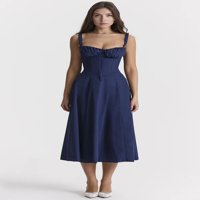


Costureira: 'Para qual categoria essa peça se destina?'
1. Camisa
2. Calça
3. Vestido
4. Saia
5. Blusa
6. Casaco
7. Acessório
8. Outro
Digite o número da categoria (1-8): 3

Costureira: 'Excelente escolha! Vou começar a produzir essa peça com o nosso estilo de arte único.'
Costureira: 'Pronto! Veja como ficou a peça digitalizada.'

Costureira: 'Aqui está a sua peça digitalizada!'


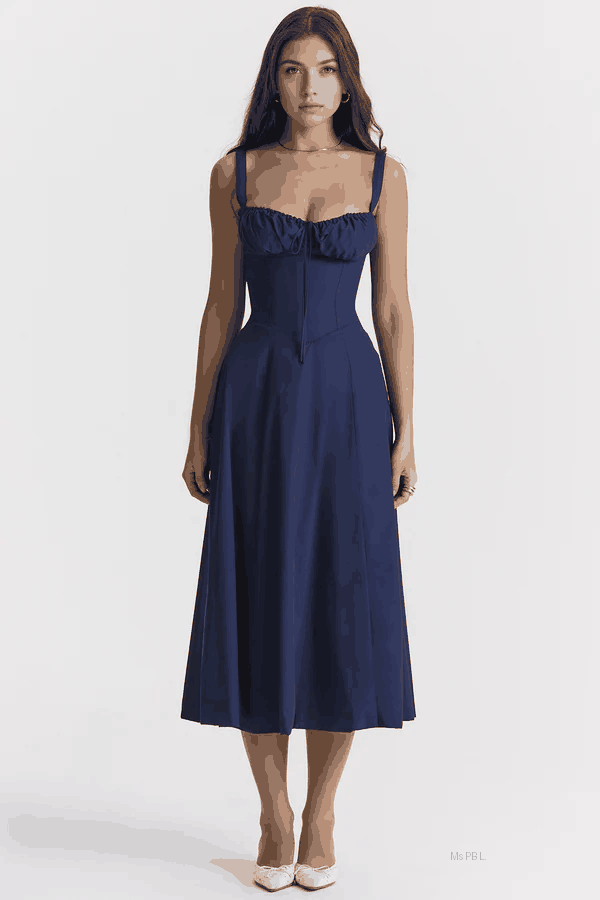

In [ ]:
# Célula 7: O Loop Principal do Jogo

def main_game_loop():
    running = True
    while running:
        costureira_saudacao()
        choice = get_player_choice()

        if choice == '1': # Criar uma nova peça para a loja
            clear_output(wait=True)
            photo = upload_piece_photo()
            if photo:
                category = identify_category()
                stylized_photo = stylize_piece(photo)

                print("\nCostureira: 'Aqui está a sua peça digitalizada!'")
                display(stylized_photo)

                piece_name = input("\nComo você gostaria de chamar esta peça? ").strip()

                while True:
                    confirm = input("Você está satisfeito(a) com a peça? (sim/nao): ").lower().strip()
                    if confirm == 'sim':
                        piece_id = str(uuid.uuid4())[:8] # Gera um ID único para a peça
                        new_piece = ClothingPiece(piece_name, category, stylized_photo, piece_id, STORE_ID)
                        CATALOG.append(new_piece) # Adiciona ao catálogo local do jogador
                        print(f"Costureira: 'Excelente! A peça '{piece_name}' foi adicionada ao catálogo da sua loja com o ID: {piece_id}.'")

                        # --- Registra a peça no banco de dados do desenvolvedor ---
                        register_piece_in_dev_db({
                            'piece_id': piece_id,
                            'piece_name': piece_name,
                            'category': category,
                            'store_id': STORE_ID,
                            'created_at': time.strftime("%Y-%m-%d %H:%M:%S")
                        })

                        # --- Publica a peça no catálogo público ---
                        public_image_url = upload_image_to_public_host(stylized_photo) # Tenta fazer o "upload"
                        if public_image_url:
                            update_public_catalog({
                                'piece_id': piece_id,
                                'name': piece_name,
                                'category': category,
                                'image_url': public_image_url,
                                'store_id': STORE_ID,
                                'store_name': STORE_NAME, # Adiciona o nome da loja para o catálogo público
                                'created_at': time.strftime("%Y-%m-%d %H:%M:%S")
                            })
                        break
                    elif confirm == 'nao':
                        print("Costureira: 'Ah, que pena! Não se preocupe, podemos tentar outra vez quando quiser.'")
                        break
                    else:
                        print("Por favor, responda 'sim' ou 'nao'.")
            else:
                print("Costureira: 'Sem a foto, não consigo criar a peça, chefe.'")

        elif choice == '2': # Ver o catálogo de peças da própria loja
            view_catalog()
            input("\nPressione Enter para voltar ao menu principal...")

        elif choice == '3': # Salvar o jogo
            save_game_state()
            input("\nJogo salvo! Pressione Enter para voltar ao menu principal...")

        elif choice == '4': # Ver o catálogo público (e comprar peças)
            view_public_catalog()

        elif choice == '5': # Sair do jogo
            running = False
            print("\nCostureira: 'Até a próxima, chefe! A loja estará aqui quando precisar.'")
            print(f"Obrigado por jogar {STORE_NAME}!")
            save_game_state() # Salva o jogo automaticamente ao sair

# Inicia o jogo
main_game_loop()